BERT

In [20]:
# Partie 1 : Importation des bibliothèques
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
import seaborn as sns

# Activation de GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [21]:
# Partie 2 : Chargement du modèle BERT et tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.to(device)
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [25]:
# Partie 3 : Définition des contextes pour un mot cible (ex: "bank")
sentences = [
    "He went to the bank to deposit money.",
    "She stood on the river bank and watched the water.",
    "The bank approved her loan application.",
    "Children played by the river bank.",
    "He opened a new account at the bank.",
    "They built a house near the bank of the river.",
    "He left the bank after 10 years of work.",
    "A boat was tied to the river bank.",
    "A tent was set up near the bank of the stream.",
    "You can’t always bank on luck — sometimes you need skill.",
    "They built their cabin near the bank for a better view.",
    "The odds are against us, but we’re still banking on success.",
    "She sat quietly on the bank, watching the current.",
    ]
target_word = "bank"


In [26]:
# Partie 4 : Extraction des embeddings BERT du mot cible dans chaque contexte
def extract_embedding(sentence, target, model, tokenizer):
    tokens = tokenizer.tokenize(sentence)
    input_ids = tokenizer.encode(sentence, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(input_ids)
    embeddings = outputs.last_hidden_state.squeeze(0)

    # Repérer l'index du mot cible (attention aux tokens de sous-mots)
    token_ids = tokenizer.convert_ids_to_tokens(input_ids[0])
    indices = [i for i, tok in enumerate(token_ids) if target in tok]
    if indices:
        vec = torch.mean(embeddings[indices], dim=0)
        return vec.cpu().numpy()
    else:
        return None

embeddings = []
valid_sentences = []
for sent in sentences:
    vec = extract_embedding(sent, target_word, model, tokenizer)
    if vec is not None:
        embeddings.append(vec)
        valid_sentences.append(sent)

embeddings = np.array(embeddings)


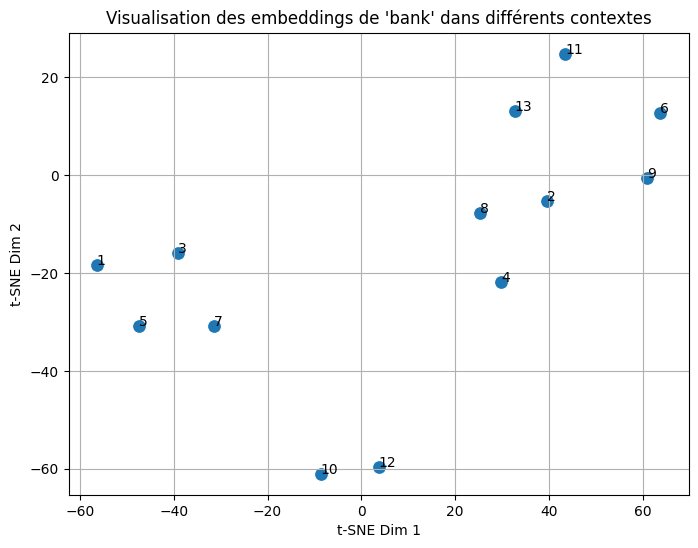

In [27]:
# Partie 5 : Visualisation en 2D avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], s=100)
for i, txt in enumerate(valid_sentences):
    plt.annotate(f"{i+1}", (emb_2d[i,0], emb_2d[i,1]), fontsize=10)
plt.title("Visualisation des embeddings de 'bank' dans différents contextes")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.show()


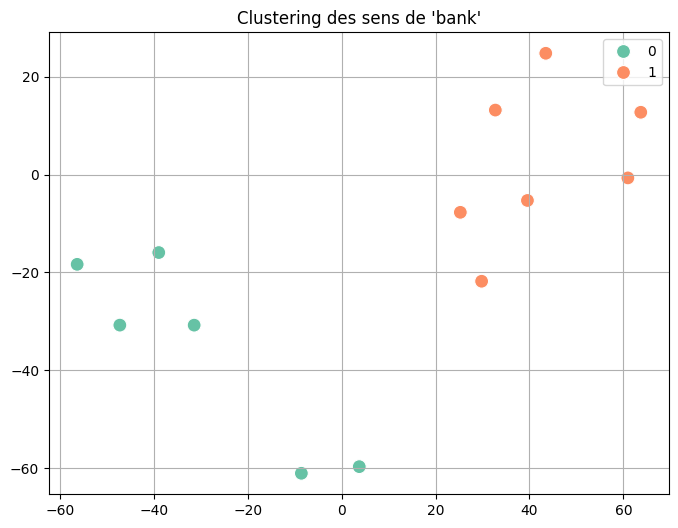

In [28]:
# Partie 6 : Clustering (ex : k-means en 2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(embeddings)

plt.figure(figsize=(8,6))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=labels, palette='Set2', s=100)
plt.title("Clustering des sens de 'bank'")
plt.grid(True)
plt.show()


In [29]:
# Partie 7 : Analyse quantitative – Distance moyenne cosinus
dist_matrix = cosine_distances(embeddings)
upper_triangle = dist_matrix[np.triu_indices(len(embeddings), k=1)]
mean_distance = np.mean(upper_triangle)

print(f"Distance moyenne cosinus entre les contextes de 'bank' : {mean_distance:.4f}")


Distance moyenne cosinus entre les contextes de 'bank' : 0.4472


In [30]:
# Partie 8 : Interprétation
for i, sent in enumerate(valid_sentences):
    print(f"[{i}] {sent} (cluster {labels[i]})")


[0] He went to the bank to deposit money. (cluster 0)
[1] She stood on the river bank and watched the water. (cluster 1)
[2] The bank approved her loan application. (cluster 0)
[3] Children played by the river bank. (cluster 1)
[4] He opened a new account at the bank. (cluster 0)
[5] They built a house near the bank of the river. (cluster 1)
[6] He left the bank after 10 years of work. (cluster 0)
[7] A boat was tied to the river bank. (cluster 1)
[8] A tent was set up near the bank of the stream. (cluster 1)
[9] You can’t always bank on luck — sometimes you need skill. (cluster 0)
[10] They built their cabin near the bank for a better view. (cluster 1)
[11] The odds are against us, but we’re still banking on success. (cluster 0)
[12] She sat quietly on the bank, watching the current. (cluster 1)


Étiquettes “réelles” (ground truth)

In [31]:
true_labels = [
    0,  # finance
    1,  # rivière
    0,
    1,
    0,
    1,
    0,
    1,
    1,
    0,
    1,
    0,
    1
]


In [32]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score

# Cas possible d'inversion des labels : KMeans n'a pas de notion de "0 = finance"
# On calcule l'accuracy avec et sans inversion pour voir la meilleure

acc1 = accuracy_score(true_labels, labels)
acc2 = accuracy_score(true_labels, 1 - labels)
accuracy = max(acc1, acc2)

ari = adjusted_rand_score(true_labels, labels)
nmi = normalized_mutual_info_score(true_labels, labels)

print(f"Accuracy (meilleure correspondance) : {accuracy:.2f}")
print(f"Adjusted Rand Index (ARI)           : {ari:.2f}")
print(f"Normalized Mutual Information (NMI) : {nmi:.2f}")


Accuracy (meilleure correspondance) : 1.00
Adjusted Rand Index (ARI)           : 1.00
Normalized Mutual Information (NMI) : 1.00


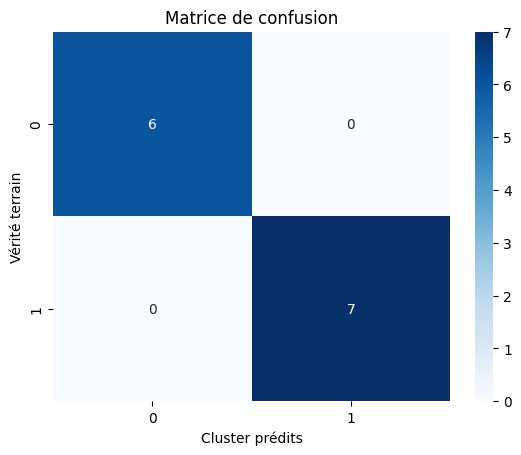

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Cluster prédits")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion")
plt.show()
